<a href="https://colab.research.google.com/github/misaelbr/coronalab/blob/master/CovidMinSaude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pytz
import requests
import folium

from folium import plugins
from textwrap import wrap
from functools import reduce
from datetime import date,datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

sns.set_style('whitegrid')

path = "./drive/My Drive/Datasets/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Lê dataset baixado do site do Ministério da Saúde

In [0]:
df = pd.read_excel(path + 'covid.xlsx', 'Sheet 1')

## Faz os cálculos de progressão de novos casos e óbitos no dataset

In [0]:
def calculaProgressao( lista, controle):
    aux = []
    for i in range(0, len( lista ) ):
        if i == 0 or controle[i] != controle[i-1]:
            aux.append( lista[i] )
        elif (lista[i] - lista[i-1]) != 0:
            aux.append( lista[i] - lista[i-1])
        else:
            aux.append(0)

    return aux


df.fillna(0, inplace=True)

df['novosCasos'] = calculaProgressao( list(df['casosAcumulado']), list(df['municipio']))
df['novosObitos'] = calculaProgressao( list(df['obitosAcumulado']), list(df['municipio']))

brasil = df[df['regiao']=='Brasil'].copy()
brasil = brasil.drop( columns=['estado', 'municipio', 'coduf', 'codmun', 'codRegiaoSaude', 'nomeRegiaoSaude'])
brasil.fillna(0, inplace=True)



## Segmentação e checagem

Esse trecho do código segementa o dataframe para dados  de municípios do RS e realiza uma checagem de consistência  entre a soma dos valores da coluna 'novosCasos' com o valor da coluna 'casosAcumulado'.

In [8]:
rs = df[df['estado']=='RS'].copy()
evol_rs = rs[rs['municipio'] == 0].copy()
municipios = rs[rs['municipio'] != 0 ].copy()

cidades = list( set(list( municipios['municipio'])))
cidades.sort()
cidades

for cidade in cidades:

    if len( municipios[(municipios['municipio']==cidade) & (municipios['data']=='2020-05-15')][['municipio','casosAcumulado']]) > 0:
        casosAcumulados = municipios[(municipios['municipio']==cidade) & (municipios['data']=='2020-05-15')][['municipio','casosAcumulado']].values[0][1] 

    if casosAcumulados != municipios[municipios['municipio']==cidade]['novosCasos'].sum():
        print('Atenção! O município de', cidade, 'tem dados inconsistentes e será removido do dataframe!')
        municipios = municipios[municipios['municipio'] != cidade ].copy()

Atenção! O município de Guabiju tem dados inconsistentes e será removido do dataframe!


## Funções para geração de gráficos

In [0]:
def cria_grafico( data ):
  fig, ax1 = plt.subplots(figsize=(20,10))


  plt.xticks(
      rotation=90, 
      horizontalalignment='center',
      fontweight='light',
      fontsize='small'  
  )
  sns.set_style('whitegrid')

  color = 'tab:green'
  

  ax1.set_title('Novos Casos / Dia', fontsize=16)
  
  ax1 = sns.barplot(x='date', y='new_cases', data = data, palette='summer')

  ax1.set_xlabel('Data', fontsize=16)
  ax1.set_ylabel('Notificações', fontsize=16)
  ax1.tick_params(axis='y')

  

  ax2 = ax1.twinx()
  color = 'tab:red'
  
  
  ax2 = sns.lineplot(x='date', y='new_deaths', data = data, sort=False, color=color)
  ax2.set_ylabel('Mortes', fontsize=16)
  ax2.tick_params(axis='y', color=color)

  show_values_on_bars( ax2 )
  
  plt.show()


def cria_grafico_evolucao( data, title, x1, y1, x2, y2 ):
  fig, ax1 = plt.subplots(figsize=(20,10))

  ax1.set(yscale="log")


  plt.xticks(
      rotation=90, 
      horizontalalignment='center',
      fontweight='light',
      fontsize='small'  
  )
  sns.set_style('whitegrid')

  color = 'tab:green'
  

  ax1.set_title(title + ' (' + datetime.now(tz=pytz.timezone("America/Sao_Paulo")).strftime('%d-%m-%Y - %H:%M') + ' GMT-03)', fontsize=16)
  
  color = 'tab:green'
  ax1 = sns.lineplot(x=x1, y=y1, data = data, sort=False, color=color)
  ax1.set_xlabel('Data', fontsize=16)
  ax1.set_ylabel('Casos', fontsize=16)
  ax1.tick_params(axis='y')

  ax2 = ax1.twinx()
  color = 'tab:red'

  ax2.set(yscale="log")
  
  
  ax2 = sns.lineplot(x=x2, y=y2, data = data, sort=False, color=color)
  ax2.set_ylabel('Mortes', fontsize=16)
  ax2.tick_params(axis='y', color=color)
  
  plt.show()


def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '  {0:,}'.format(int(p.get_height())).replace(',','.')
            if value == '  0':
                value = ''
            ax.text(_x, _y, value, ha="center", rotation=90) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


def cria_grafico_cidade( data, title, x, y, gravar=True, size=(18,12)):
  fig, ax1 = plt.subplots(figsize=size)

  plt.xticks(
      rotation=90, 
      horizontalalignment='center',
      fontweight='light',
      fontsize='medium'  
  )

  plt.ticklabel_format(style='plain', axis='y')


  color = 'tab:green'

  ax1.set_title(title + ' (' + datetime.now(tz=pytz.timezone("America/Sao_Paulo")).strftime('%d-%m-%Y - %H:%M') + ' GMT-03)', fontsize=16)
  ax1 = sns.barplot(x=x, y=y, data = data, estimator=np.median, )
  ax1.set_xlabel('Local', fontsize=16)
  ax1.set_ylabel('Notificações', fontsize=16)
  ax1.tick_params(axis='y')

  show_values_on_bars(ax1)

  #ax2 = ax1.twinx()
  #color = 'tab:red'
  
  #ax2.set_ylabel('Novas Mortes / Dia', fontsize=16)
  #ax2 = sns.lineplot(x='city', y='deaths', data = data, sort=False, color=color)
  #ax2.tick_params(axis='y', color=color)

  caminho = path + 'gráficos_covid/' + datetime.now(tz=pytz.timezone("America/Sao_Paulo")).strftime('%d-%m-%Y')
  if gravar:
    if not os.path.exists(caminho):
        os.makedirs( caminho )
                
    nome = title 
    arquivo = caminho + "/" + (nome.replace(".","_").replace(" ", "_").replace("/","_"))
    try:
        plt.savefig( arquivo )        
    except:
        print('Ocorreu um erro! Erro:', sys.exc_info()[0])
             
  plt.show()

  


## Segmentação de dados para geração de gráficos em uma data específica

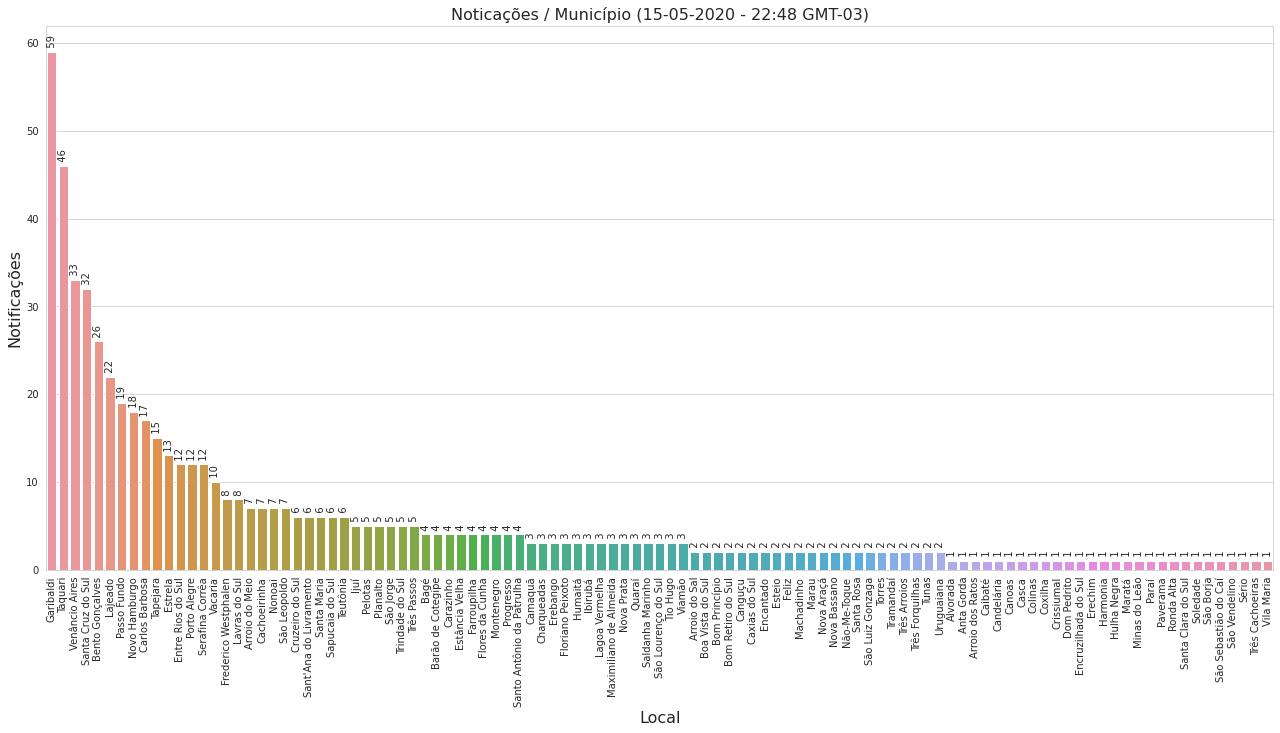

In [10]:
graf_notificaoes_data = municipios[(municipios['data']=='2020-05-15')&(
    (municipios['novosCasos']>0) | 
    (municipios['novosObitos']>0))][
                ['municipio','novosCasos', 'novosObitos']
                ].sort_values(by=['novosCasos','municipio'], ascending=[False,True])

cria_grafico_cidade( graf_notificaoes_data, 'Noticações / Município', 'municipio', 'novosCasos', size=(22,10))

In [0]:
## Carrega e segmenta os dados de GPS para plotagem

In [0]:
df_gps = pd.read_csv('https://github.com/wcota/covid19br/raw/master/cases-gps.csv')
df_gps['UF'] = df_gps.apply( lambda x: x['name'].split('/')[1], axis=1)
df_gps['name'] = df_gps.apply( lambda x: x['name'].split('/')[0], axis=1)


gps2 = pd.read_csv('https://github.com/wcota/covid19br/raw/master/cases-brazil-cities-time_changesOnly.csv')




## Segmenta e exibe o total de casos acumulados no RS

In [43]:
dados_rs = df_gps[df_gps['UF']=='RS'].copy()

casos_rs = dados_rs[dados_rs['type'] == '1' ].copy()

cidades = list(set(casos_rs['name']))
cidades.sort()


casos_lat = []
casos_lon = []
name = []
for cidade in cidades:
    x = casos_rs[casos_rs['name']==cidade]['total'].values[0]
    for i in range(0,x):
        casos_lat.append(casos_rs[casos_rs['name']==cidade]['lat'].values[0])
        casos_lon.append(casos_rs[casos_rs['name']==cidade]['lon'].values[0])
        name.append( cidade.encode('latin-1') )
        

latitude = pd.DataFrame( casos_lat, columns=['lat'])
longitude = pd.DataFrame( casos_lon, columns=['lon'])
name = pd.DataFrame( name, columns=['municipio'])

coordinates = pd.concat( [name, latitude, longitude],   axis=1 )

m = folium.Map(
    location=[-29.2973463,-53.5358781],zoom_start=6.5,
    tiles='Stamen Terrain'
)
mc = plugins.MarkerCluster()

for row in coordinates.itertuples():
    mc.add_child( folium.Marker( 
        location=[row.lat, row.lon], 
        popup=row.municipio,
        icon=folium.Icon(color='red', icon='info-sign')
        )
    )

estado_jsons = requests.get("https://servicodados.ibge.gov.br/api/v2/malhas/43/?formato=application/vnd.geo+json&resolucao=1",
                           headers=headers)
estado_json = estado_jsons.json()
folium.GeoJson(estado_json).add_to(m)
m.add_child( mc )

tiles = ['openstreetmap','Mapbox Bright','Mapbox Control Room',
        'stamenterrain','stamenterrain','stamentoner',
        'stamenwatercolor','cartodbpositron','cartodbdark_matter']
for tiles_ in tiles: 
  folium.TileLayer(tiles_).add_to(m)
folium.LayerControl().add_to(m)
m

## Lê dataset com as informações de gps por localização


In [0]:
gps = pd.read_csv('https://github.com/wcota/covid19br/raw/master/gps_cities.csv')
gps['UF'] = gps.apply( lambda x: x['id'].split('/')[1], axis=1)
gps['id'] = gps.apply( lambda x: x['id'].split('/')[0], axis=1)

gps_rs = gps[gps['UF']=='RS'].copy()

## Plota os novos casos reportados em uma data específica



In [45]:
novos_casos_mapa = graf_notificaoes_data[graf_notificaoes_data['novosCasos']>0].copy()


# dados_rs = df_gps[df_gps['UF']=='RS'].copy()

# casos_rs = dados_rs[dados_rs['type'] == '1' ].copy()

cidades = list(set(novos_casos_mapa['municipio']))
cidades.sort()


casos_lat = []
casos_lon = []
name = []
for cidade in cidades:
    x = novos_casos_mapa[novos_casos_mapa['municipio']==cidade]['novosCasos'].values[0]
    for i in range(0,x):
        casos_lat.append(gps_rs[gps_rs['id']==cidade]['lat'].values[0])
        casos_lon.append(gps_rs[gps_rs['id']==cidade]['lon'].values[0])
        name.append( cidade.encode('latin-1') )
        

latitude = pd.DataFrame( casos_lat, columns=['lat'])
longitude = pd.DataFrame( casos_lon, columns=['lon'])
name = pd.DataFrame( name, columns=['municipio'])

coordinates = pd.concat( [name, latitude, longitude],   axis=1 )

m = folium.Map(
    location=[-29.2973463,-53.5358781],zoom_start=6.5,
    tiles='Stamen Terrain'
)
mc = plugins.MarkerCluster()

for row in coordinates.itertuples():
    mc.add_child( folium.Circle( 
        location=[row.lat, row.lon], 
        radius=1500, 
        fill=True,
        popup=row.municipio,
        fill_color='red',
        color='red' ))

estado_jsons = requests.get("https://servicodados.ibge.gov.br/api/v2/malhas/43/?formato=application/vnd.geo+json&resolucao=2",
                           headers=headers)
estado_json = estado_jsons.json()
folium.GeoJson(estado_json).add_to(m)
m.add_child( mc )
m

## Plota os novos óbitos reportados em uma data específica


In [24]:
novos_casos_mapa = graf_notificaoes_data[graf_notificaoes_data['novosObitos']>0].copy()


# dados_rs = df_gps[df_gps['UF']=='RS'].copy()

# casos_rs = dados_rs[dados_rs['type'] == '1' ].copy()

cidades = list(set(novos_casos_mapa['municipio']))
cidades.sort()


casos_lat = []
casos_lon = []
name = []
for cidade in cidades:
    x = novos_casos_mapa[novos_casos_mapa['municipio']==cidade]['novosObitos'].values[0]
    for i in range(0,x):
        casos_lat.append(gps_rs[gps_rs['id']==cidade]['lat'].values[0])
        casos_lon.append(gps_rs[gps_rs['id']==cidade]['lon'].values[0])
        name.append( cidade )
        

latitude = pd.DataFrame( casos_lat, columns=['lat'])
longitude = pd.DataFrame( casos_lon, columns=['lon'])
name = pd.DataFrame( name, columns=['municipio'])

coordinates = pd.concat( [name, latitude, longitude],   axis=1 )

m = folium.Map(
    location=[-29.2973463,-53.5358781],zoom_start=6.5,
    tiles='Stamen Terrain'
)
mc = plugins.MarkerCluster()

for row in coordinates.itertuples():
    mc.add_child( folium.Circle( 
        location=[row.lat, row.lon], 
        radius=1500, 
        fill=True,
        popup=row.municipio,
        fill_color='red',
        color='red' ))

estado_jsons = requests.get("https://servicodados.ibge.gov.br/api/v2/malhas/43/?formato=application/vnd.geo+json&resolucao=2",
                           headers=headers)
estado_json = estado_jsons.json()
folium.GeoJson(estado_json).add_to(m)
m.add_child( mc )
m